#### This Example creates a CNN to detect hand written numbers. The net is trained with the MNIST dataset. To optimize for FPGAs, the CNN is trained with quantizsation awareness. After training, the parameters are exported as VHDL constants.

Import everything needed

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from keras.regularizers import l2
from tensorflow.keras.datasets import mnist #this library contains a lot of ML datasets including the MNIST one
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import pickle #pickle is a library that helps us save a lot of different types of data - anything ranging from Pandas dataframes to TensorFlow models
from tensorflow import keras
!pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.keras import compat as tf_compat
from tensorflow_model_optimization.python.core.quantization.keras.experimental.default_n_bit import default_n_bit_quantize_registry as n_bit_registry
import numpy as np
from tensorflow.python.training import moving_averages
from tensorflow.python.ops import math_ops

quantize_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_model = tfmot.quantization.keras.quantize_annotate_model
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_annotate_model = tfmot.quantization.keras.quantize_annotate_model
quantize_scope = tfmot.quantization.keras.quantize_scope

Load the MNIST dataset

In [5]:
input_shape = (28, 28, 1)
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

train_data /= 255
test_data /= 255

11490434/11490434 [==============================] - 2s 0us/step


Create quantization awareness for FPGA power of 2 quantization

In [6]:
def _FakeQuantWithMinMaxVars(inputs, min_var, max_var, per_channel, num_bits,
                             narrow_range):

  if per_channel:
    assert len(min_var.get_shape()) == 1
    assert len(max_var.get_shape()) == 1
    return tf.quantization.fake_quant_with_min_max_vars_per_channel(
        inputs, min_var, max_var, num_bits=num_bits, narrow_range=narrow_range)
  else:
    assert min_var.get_shape() == []  # pylint: disable=g-explicit-bool-comparison
    assert max_var.get_shape() == []  # pylint: disable=g-explicit-bool-comparison
    return tf.quantization.fake_quant_with_min_max_vars(
        inputs, min_var, max_var, num_bits=num_bits, narrow_range=narrow_range)

def MovingAvgQuantize(inputs,
                      min_var,
                      max_var,
                      per_channel=False,
                      ema_decay=0.999,
                      name_prefix='MovingAvgQuantize',
                      is_training=True,
                      num_bits=8,
                      narrow_range=False,
                      symmetric=False):

  with tf.name_scope(name_prefix):
    input_shape = inputs.get_shape()
    input_dim = len(input_shape)

    if not is_training:
      return _FakeQuantWithMinMaxVars(
          inputs,
          min_var,
          max_var,
          per_channel=per_channel,
          num_bits=num_bits,
          narrow_range=narrow_range)
    if per_channel:
      if input_dim == 2:
        reduce_dims = [0]
      elif input_dim == 4:
        reduce_dims = [0, 1, 2]

    if per_channel:
      if input_dim >= 2:
        batch_min = tf.math.reduce_min(
            inputs, axis=reduce_dims, name='BatchMin')
      else:
        batch_min = inputs
    else:
      batch_min = tf.math.reduce_min(inputs, name='BatchMin')

    # modified by sf
    # ensure batch_min is not 0
    batch_min = math_ops.minimum(batch_min, -0.0000001)
    # end modified by sf

    if per_channel:
      if input_dim >= 2:
        batch_max = tf.math.reduce_max(
            inputs, axis=reduce_dims, name='BatchMax')
      else:
        batch_max = inputs
    else:
      batch_max = tf.math.reduce_max(inputs, name='BatchMax')

    # modified by sf
    # ensure batch_max is not 0
    batch_max = math_ops.maximum(batch_max, 0.0000001)
    # end modified by sf

    if symmetric:
      if narrow_range:
        min_max_ratio = -1
      else:
        # In two's complement notation, the negative range is slightly larger
        # than the positive range.
        min_max_ratio = -((1 << num_bits) - 2) / (1 << num_bits)

      # TFLite requires that 0.0 if always in the [min; max] range. Because
      # batch_min <= batch_max, it follows that range_min <= 0 <= range_max.
      range_min = tf.minimum(batch_min, batch_max / min_max_ratio)
      range_max = tf.maximum(batch_max, batch_min * min_max_ratio)
    else:
      # TFLite requires that 0.0 if always in the [min; max] range.
      range_min = tf.minimum(batch_min, 0.0)
      range_max = tf.maximum(batch_max, 0.0)

    assign_min = moving_averages.assign_moving_average(
        min_var, range_min, ema_decay, zero_debias=False, name='AssignMinEma')
    assign_max = moving_averages.assign_moving_average(
        max_var, range_max, ema_decay, zero_debias=False, name='AssignMaxEma')

    # modified by sf
    min_log = tf.math.ceil(tf.math.log(tf.math.abs(assign_min))/tf.math.log(2.0))
    max_log = tf.math.ceil(tf.math.log(tf.math.abs(assign_max))/tf.math.log(2.0))
    minmax_log = math_ops.maximum(min_log,max_log)
    min_po2 = tf.math.negative(tf.math.pow(2.0,minmax_log))
    max_po2 = tf.math.pow(2.0,minmax_log)-tf.math.pow(2.0,minmax_log-7)

    assign_min_po2 = tf_compat.assign(assign_min,min_po2,name='AssignMinPo2MovAvg')
    assign_max_po2 = tf_compat.assign(assign_max,max_po2,name='AssignMaxPo2MovAvg')

    return _FakeQuantWithMinMaxVars(
        inputs,
        assign_min_po2,
        assign_max_po2,
        per_channel=per_channel,
        num_bits=num_bits,
        narrow_range=narrow_range)

class _QuantizeHelper(object):
  """Mixin with helper functions for quantizers."""

  def _add_range_weights(self, layer, name, per_axis=False, tensor_shape=None):
    """Add min and max vars to layer."""
    shape = None
    if per_axis and tensor_shape is not None:
      shape = (tensor_shape[-1])

    min_weight = layer.add_weight(
        name + '_min',
        initializer=keras.initializers.Constant(-6.0),
        trainable=False,
        shape=shape)
    max_weight = layer.add_weight(
        name + '_max',
        initializer=keras.initializers.Constant(6.0),
        trainable=False,
        shape=shape)

    return {'min_var': min_weight, 'max_var': max_weight}

class FixedRangeQuantizer(_QuantizeHelper, tfmot.quantization.keras.quantizers.Quantizer):
  def __init__(self, num_bits = 8, per_axis = False, symmetric = True, narrow_range = True):
    self.num_bits = num_bits
    self.per_axis = per_axis
    self.symmetric = symmetric
    self.narrow_range = narrow_range

  def build(self, tensor_shape, name, layer):
    return self._add_range_weights(layer, name)

  def __call__(self, inputs, training, weights, **kwargs):
    return MovingAvgQuantize(
        inputs,
        weights['min_var'],
        weights['max_var'],
        ema_decay=0.999,
        is_training=training,
        num_bits=self.num_bits,
        per_channel=self.per_axis,
        symmetric=self.symmetric,
        narrow_range=self.narrow_range
    )

  def get_config(self):
    return {
        'num_bits': self.num_bits,
        'per_axis': self.per_axis,
        'symmetric': self.symmetric,
        'narrow_range': self.narrow_range
    }

class ModifiedDenseQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):
    def get_weights_and_quantizers(self, layer):
      # Use custom algorithm defined in `FixedRangeQuantizer` instead of default Quantizer.
      return [(layer.kernel, FixedRangeQuantizer(num_bits = 8, per_axis = False, symmetric = True, narrow_range = True))]
      #return []

    # Configure how to quantize activations.
    def get_activations_and_quantizers(self, layer):
      return [(layer.activation, FixedRangeQuantizer(num_bits = 8, per_axis = False, symmetric = True, narrow_range = True))]
      #return []

    def set_quantize_weights(self, layer, quantize_weights):
      # Add this line for each item returned in `get_weights_and_quantizers`
      # , in the same order
      layer.kernel = quantize_weights[0]
      #pass

    def set_quantize_activations(self, layer, quantize_activations):
      # Add this line for each item returned in `get_activations_and_quantizers`
      # , in the same order.
      layer.activation = quantize_activations[0]
      #pass

    # Configure how to quantize outputs (may be equivalent to activations).
    def get_output_quantizers(self, layer):
      return []
      #if self.quantize_output:
      #  return [FixedRangeQuantizer()]
      #return []

    def get_config(self):
      return {}
      #return {'quantize_output': self.quantize_output}

class ModifiedConvQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):
    def get_weights_and_quantizers(self, layer):
      # Use custom algorithm defined in `FixedRangeQuantizer` instead of default Quantizer.
      return [(layer.kernel, FixedRangeQuantizer(num_bits = 8, per_axis = False, symmetric = True, narrow_range = True))]

    # Configure how to quantize activations.
    def get_activations_and_quantizers(self, layer):
      return [(layer.activation, FixedRangeQuantizer(num_bits = 8, per_axis = False, symmetric = True, narrow_range = True))]

    def set_quantize_weights(self, layer, quantize_weights):
      # Add this line for each item returned in `get_weights_and_quantizers`
      # , in the same order
      layer.kernel = quantize_weights[0]

    def set_quantize_activations(self, layer, quantize_activations):
      # Add this line for each item returned in `get_activations_and_quantizers`
      # , in the same order.
      layer.activation = quantize_activations[0]

    # Configure how to quantize outputs (may be equivalent to activations).
    def get_output_quantizers(self, layer):
      return []

    def get_config(self):
      return {}

Define the neural network (can be customized for different applications)

In [7]:
# Set resolution and activation max value
weight_bits = 8
value_bits = 9
max_value = 2**(value_bits-(weight_bits-1))

act = 'relu'

model = quantize_model(keras.Sequential([
  keras.layers.InputLayer(input_shape=input_shape),
  quantize_layer(keras.layers.Conv2D(4, (3, 3), activation=act, kernel_initializer='he_normal', padding='same', strides=(1,1)), quantize_config=ModifiedConvQuantizeConfig()),
  keras.layers.MaxPooling2D((2, 2), padding='valid'),
  quantize_layer(keras.layers.Conv2D(6, (3, 3), activation=act, kernel_initializer='he_normal', padding='same', strides=(1,1)), quantize_config=ModifiedConvQuantizeConfig()),
  keras.layers.MaxPooling2D((2, 2), padding='valid'),
  quantize_layer(keras.layers.Conv2D(8, (3, 3), activation=act, kernel_initializer='he_normal', padding='same', strides=(1,1)), quantize_config=ModifiedConvQuantizeConfig()),
  keras.layers.MaxPooling2D((2, 2), padding='valid'),
  quantize_layer(keras.layers.Flatten()),
  quantize_annotate_layer(keras.layers.Dense(10, activation='softmax'), ModifiedDenseQuantizeConfig())
]))

with quantize_scope({'ModifiedDenseQuantizeConfig': ModifiedDenseQuantizeConfig}, {'ModifiedConvQuantizeConfig': ModifiedConvQuantizeConfig}):
  # Use `quantize_apply` to actually make the model quantization aware.
  q_aware_model = tfmot.quantization.keras.quantize_apply(model)

Train the neural network

In [8]:
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()

history = q_aware_model.fit(train_data, train_labels, epochs=10, validation_data=(test_data, test_labels))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28, 1)        3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 28, 28, 4)        45        
 erV2)                                                           
                                                                 
 quant_max_pooling2d (Quanti  (None, 14, 14, 4)        1         
 zeWrapperV2)                                                    
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 14, 14, 6)        227       
 pperV2)                                                         
                                                                 
 quant_max_pooling2d_1 (Quan  (None, 7, 7, 6)          1

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1875/1875 [==============================] - 33s 10ms/step - loss: 0.4485 - accuracy: 0.8570 - val_loss: 0.1727 - val_accuracy: 0.9442


Check if everything works

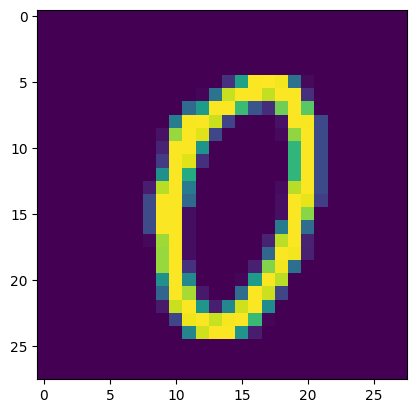

Number =  0
1/1 [==============================] - 0s 212ms/step
Probability for number =  0 :  99.65753 %
Probability for number =  1 :  0.00124 %
Probability for number =  2 :  0.01526 %
Probability for number =  3 :  0.00096 %
Probability for number =  4 :  8e-05 %
Probability for number =  5 :  0.00719 %
Probability for number =  6 :  0.03239 %
Probability for number =  7 :  0.08841 %
Probability for number =  8 :  0.18771 %


In [9]:
test_nummer = 1000
from matplotlib import pyplot as plt
plt.imshow(train_data[test_nummer], interpolation='nearest')
plt.show()
print("Number = ", train_labels[test_nummer])

predict = q_aware_model.predict(train_data[test_nummer:test_nummer+1])[0]
for o in range(0,9):
  print('Probability for number = ' , o, ': ', np.round(predict[o]*100,5), '%')

Extract weights from trensorflow CNN

In [11]:
# layers: model.get_weights()
def extract_weights(layers, log = False, quant = False):
  # output array:
  #  1. dimension = layer
  #  2. dimension = filters/outputs
  #  3. dimension = inputs
  data_out = []
  # parameters output:
  #  1. dimension = layer
  #  2. dimension:
  #   [0] = type (1 = Conv2D, 2 = Dense, 3 = Normalization, 4 = Quantize, 5 = Middle Point)
  #   [1] = max weight value (max weight value 1 for normalization)
  #   [2] = input filters    (max weight value 2 for normalization)
  #   [3] = output filters   (max weight value 3 for normalization)
  #   [4] = rows             (max weight value 4 for normalization)
  #   [5] = columns          (input filters for normalization)
  #   [6] = middle point
  #   [7] = min value(s)
  #   [8] = max value(s)
  #   [9] = min activation value
  #   [10] = min activation value
  param_out = []

  # ----------- parameters for convolutional layers ------------
  # Number of convolutional layers in this neural network
  r_conv_layers = 0
  # Maximum number of filters in one layer
  r_max_filter = 0
  # Maximum number of input values for one filter (rows * columns * input filters)
  r_max_elements = 0
  # Maximum values for weights and biases of every layer
  r_max_values = []

  layer_counter = 0
  inputs = 0
  last_was_conv = False
  last_was_fc = False
  last_type = 0 # 0 = No Layer, 1 = Fully Connected, 2 = Convolution
  value_counter = 0 # 0 = bias, 1 = middle point, 2 = min values, 3 = max values, 4 = activation min, 5 = activation max
  output_filters = 0
  conv_matrix_size = 0
  normalization_layer_row = 0

  fc_input = 0
  conv_row = 0
  conv_column = 0

  # go through layers in the weights array
  for layer in layers:
    if isinstance(layer,np.float32) or isinstance(layer,np.int32):
      if last_type == 0:
        if value_counter < 3:
          if value_counter == 0:
            # add quantize layer
            if log:
              print('add Quantize')
            layer_counter = layer_counter + 1
            data_out.append(np.zeros((3)))
            param_out.append(np.zeros((1)))
            param_out[layer_counter-1][0] = 4
          data_out[layer_counter-1][value_counter] = layer
      elif value_counter < 6:
        if last_type == 1:
          param_out[layer_counter-1][value_counter+5] = layer
          #for i in range(len(data_out[layer_counter-1])):
          #  data_out[layer_counter-1][i][inputs+value_counter] = layer
        else:
          param_out[layer_counter-1].append(layer)
          #for i in range(len(data_out[layer_counter-1])):
          #  data_out[layer_counter-1][i][inputs*conv_matrix_size+value_counter] = layer
      else:
        if log:
          print('add Middle Point')
        layer_counter = layer_counter + 1
        data_out.append(np.zeros((1)))
        param_out.append(np.zeros((1)))
        data_out[layer_counter-1][0] = layer
        param_out[layer_counter-1][0] = 5

      value_counter = value_counter + 1
    else:
      # check if this is the bias of the last layer or the parameters of a normalization layer
      if isinstance(layer[0],np.float32):
        #print("1")

        bias_index = 0
        if last_type == 2 and value_counter < 6 and value_counter > 0 and quant:
          param_out[layer_counter-1].append(layer)
        else:
          for bias_value in layer:
            # save the highest value for a weight or bias to calculate the bits for the integral parts of the values
            if last_was_conv or last_was_fc:
              if np.abs(bias_value) > param_out[layer_counter-1][1]:
                param_out[layer_counter-1][1] = np.abs(bias_value)

            # check if this is the bias of a convolutional layer
            if last_was_conv:
              data_out[layer_counter-1][bias_index][inputs*conv_matrix_size] = bias_value
              normalization_layer_row = 0
              last_type = 2
              value_counter = 0
            # check if this is the bias of a fully connected layer
            elif last_was_fc:
              data_out[layer_counter-1][bias_index][inputs] = bias_value
              normalization_layer_row = 0
              last_type = 1
              value_counter = 0
            # otherwise this must be a normaliaztion layzer
            elif not quant:
              if normalization_layer_row == 1 and bias_index == 0:
                param_out.append(np.zeros(6))
                data_out.append(np.zeros((4,len(layer))))
                if log:
                  print('add Normalization')
                layer_counter = layer_counter + 1
                # save parameters of normalization layer
                param_out[layer_counter-1][0] = 3               # type = normalization
                param_out[layer_counter-1][5] = len(layer)      # input values
              if normalization_layer_row == 4:
                bias_value = 1/np.sqrt(bias_value)
              # check for maximum parameter for this type of parameter
              if np.abs(bias_value) > param_out[layer_counter-1][normalization_layer_row]:
                param_out[layer_counter-1][normalization_layer_row] = np.abs(bias_value)
              # save parameters in list (add calculation to last parameter)
              data_out[layer_counter-1][normalization_layer_row-1][bias_index] = bias_value

            bias_index = bias_index + 1

        normalization_layer_row = normalization_layer_row + 1
        last_was_fc   = False
        last_was_conv = False
        value_counter = value_counter + 1
      else:
        for weight_row in layer:
          # if this layer only has one row of weights, this is a fully connected layer
          if isinstance(weight_row[0],np.float32):
            #print("2")

            # check if this is the first set of weights in this fully connected layer
            if not last_was_fc:
              if quant:
                param_out.append(np.zeros(11))
              else:
                param_out.append(np.zeros(4))
              data_out.append(np.zeros((len(weight_row),len(layer)+1)))
              if log:
                print('add Dense')
              layer_counter = layer_counter + 1
              fc_input = 0
              # save parameters of fully connected layer
              param_out[layer_counter-1][0] = 2               # type = fully connected
              param_out[layer_counter-1][2] = len(layer)      # input values
              param_out[layer_counter-1][3] = len(weight_row) # output values
              inputs = len(layer)

            fc_output = 0
            for weight in weight_row:
              # save weights in list
              data_out[layer_counter-1][fc_output][fc_input] = weight
              fc_output = fc_output + 1
              #
              if np.abs(weight) > param_out[layer_counter-1][1]:
                  param_out[layer_counter-1][1] = np.abs(weight)

            fc_input = fc_input + 1
            last_was_fc   = True
            last_was_conv = False
          else:
            # go through weight columns
            for weight_column in weight_row:
              # a convolutional layer has for one input a list of weights for each filter
              if not isinstance(weight_column[0],np.float32):
                #print("3")

                # check if this is the first set of weights in this convolutional layer
                if not last_was_conv:
                  # save parameters of convolutional layer
                  param_out.append([])
                  data_out.append(np.zeros((len(weight_column[0]),len(layer)*len(weight_row)*len(weight_column)+1)))

                  if log:
                    print('add Conv2D')
                  layer_counter = layer_counter + 1
                  conv_row = 0
                  conv_column = 0
                  last_was_fc   = False
                  last_was_conv = True
                  # save parameters of fully connected layer
                  param_out[layer_counter-1].append(1)                     # type = convolution
                  param_out[layer_counter-1].append(0)                     # max weight = 0
                  param_out[layer_counter-1].append(len(weight_column))    # input values
                  param_out[layer_counter-1].append(len(weight_column[0])) # output values
                  param_out[layer_counter-1].append(len(layer))            # rows
                  param_out[layer_counter-1].append(len(weight_row))       # columns
                  inputs = len(weight_column)
                  conv_matrix_size = len(layer)*len(weight_row)

                # save the highest value for a weight or bias
                conv_input = 0
                for input_filter in weight_column:
                  conv_output = 0
                  for output_filter_weight in input_filter:
                    data_out[layer_counter-1][conv_output][conv_row*len(weight_row)*len(weight_column)+conv_column*len(weight_column)+conv_input] = output_filter_weight
                    if np.abs(output_filter_weight) > param_out[layer_counter-1][1]:
                      param_out[layer_counter-1][1] = np.abs(output_filter_weight)

                    conv_output = conv_output + 1
                  conv_input = conv_input + 1
                conv_column = conv_column + 1
            conv_row = conv_row + 1
            conv_column = 0

  return [data_out, param_out]

print('Found:', len(extract_weights(q_aware_model.get_weights(), True, True)[0]), 'layers')

add Quantize
add Conv2D
add Middle Point
add Conv2D
add Middle Point
add Conv2D
add Middle Point
add Middle Point
add Dense
Found: 9 layers


Define some helpfull functions

In [12]:
def reject_outliers_2(data, m=2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / (mdev if mdev else 1.)
    return data[s < m]

def clip_values(int_bits, bits, negativ):
  if int_bits < 0 and not negativ:
    int_bits = 0
  elif int_bits < (bits-2)*(-1):
    int_bits = (bits-2)*(-1)
  if int_bits > bits-2:
    int_bits = bits-2
  return int_bits

def calc_scale(val, scale_bits):
  if abs(val) > 0:
    int_bits = int(np.ceil(np.log2(abs(val))))
  else:
    int_bits = 0
  if int_bits > scale_bits-1:
    int_bits = scale_bits-1

Export the parameters of the net for VHDP

In [13]:
def np_to_vhdp_array(arr, param, fpga = False, bits = 8, tolerance = 0, norm = False, negativ = True, conv = 0, quant = False, scale_bits = 8, power_of_2 = False):
  arr = np.array(arr)
  if fpga:
    #prüfen ob mit outlierer raus oder mit offset_min besseres ergebnis
    #auch bei normalen weights prüfen
    # Normalization ############################################################
    if norm:
      for i in range(4):
        data = arr[i]

        int_bits = int(np.ceil(np.log2(param[i+1])-tolerance))

        if i == 0 or i == 3: # Wird multipliziert und 0 sollte vermieden werden
          offset_max = int(np.ceil(np.log2(min(abs(data[data != 0])))))+(bits-5)
          if int_bits > offset_max:
            int_bits = int(offset_max)

        int_bits = clip_values(int_bits, bits, negativ)
        offset_type = 'G'
        if i == 1:
          offset_type = 'B'
        elif i == 2:
          offset_type = 'M'
        elif i == 3:
          offset_type = 'S'
        print('  CONSTANT Normalization_',conv ,'_',offset_type,'_Offset   : INTEGER := ', int_bits, ';', sep='')
        arr[i] = np.clip(np.round(arr[i] * 2**(bits-int_bits-1), 0), (-1)*(2**(bits-1)-1), (2**(bits-1)-1))
      print('  CONSTANT Normalization_',conv ,' : CNN_Parameters_T(0 to 3, 0 to Normalization_',conv ,'_Values-1) :=', sep='')
      arr = arr.astype(int)
    else:
      # Quantized ##############################################################
      if quant and not power_of_2:
        # activation scale and middle
        scale  = (2**bits-1)/(param[10]-param[9])
        middle = (param[10]-(param[10]-param[9])/2)*scale

        int_bits = calc_scale(scale, scale_bits)
        scale_int  = np.clip(np.round(scale  * 2**(scale_bits-int_bits-1), 0), (-1)*(2**(scale_bits-1)-1), (2**(scale_bits-1)-1)).astype(int)

        if param[0] == 1:
          print('  CONSTANT Layer_',conv ,'_Activation_Scale_Offset  : INTEGER := ', int_bits, ';', sep='')
          print('  CONSTANT Layer_',conv ,'_Activation_Scale         : CNN_Parameter_T := ', scale_int, ';', sep='')
        else:
          print('  CONSTANT NN_Layer_',conv ,'_Activation_Scale_Offset  : INTEGER := ', int_bits, ';', sep='')
          print('  CONSTANT NN_Layer_',conv ,'_Activation_Scale         : CNN_Parameter_T := ', scale_int, ';', sep='')

        int_bits = calc_scale(middle, scale_bits)
        middle_int = np.clip(np.round(middle * 2**(scale_bits-int_bits-1), 0), (-1)*(2**(scale_bits-1)-1), (2**(scale_bits-1)-1)).astype(int)

        if param[0] == 1:
          print('  CONSTANT Layer_',conv ,'_Activation_Middle_Offset : INTEGER := ', int_bits, ';', sep='')
          print('  CONSTANT Layer_',conv ,'_Activation_Middle        : CNN_Parameter_T := ', middle_int, ';', sep='')
        else:
          print('  CONSTANT NN_Layer_',conv ,'_Activation_Middle_Offset : INTEGER := ', int_bits, ';', sep='')
          print('  CONSTANT NN_Layer_',conv ,'_Activation_Middle        : CNN_Parameter_T := ', middle_int, ';', sep='')

        # Comvolution ##########################################################
        if param[0] == 1:
          scale  = []
          middle = []

          for i in range(len(param[7])):
            scale.append((2**bits-1)/(param[8][i]-param[7][i]))
            middle.append((param[8][i]-(param[8][i]-param[7][i])/2)*scale[i])

          max = np.amax(abs(np.asarray(scale)))
          int_bits = calc_scale(max, scale_bits)
          scale_int  = np.clip(np.round(np.asarray(scale)  * 2**(scale_bits-int_bits-1), 0), (-1)*(2**(scale_bits-1)-1), (2**(scale_bits-1)-1)).astype(int)
          print('  CONSTANT Layer_',conv ,'_Scale_Offset  : INTEGER := ', int_bits, ';', sep='')

          max = np.amax(abs(np.asarray(middle)))
          int_bits = calc_scale(max, scale_bits)
          middle_int = np.clip(np.round(np.asarray(middle) * 2**(scale_bits-int_bits-1), 0), (-1)*(2**(scale_bits-1)-1), (2**(scale_bits-1)-1)).astype(int)
          print('  CONSTANT Layer_',conv ,'_Middle_Offset : INTEGER := ', int_bits, ';', sep='')

          print('  CONSTANT Layer_',conv ,'_Scale         : CNN_Parameters_T(0 to 1, 0 to Layer_',conv ,'_Filters-1) :=', sep='')
          print('  (')
          print('    (', end = '')
          start = True
          for s in scale_int:
            if start:
              start = False
            else:
              print(', ', end = '')

            print(s, end = '')
          print('),')
          print('    (', end = '')
          start = True
          for s in middle_int:
            if start:
              start = False
            else:
              print(', ', end = '')

            print(s, end = '')
          print(')')
          print('  );')

          print('  CONSTANT Layer_',conv ,' : CNN_Weights_T(0 to Layer_',conv ,'_Filters-1, 0 to Layer_',conv ,'_Inputs-1) :=', sep='')
          for i in range(len(arr)):
            arr[i] = np.clip(np.round(arr[i] * scale[i] + middle[i], 0), (-1)*(2**(bits-1)-1), (2**(bits-1)-1))
          arr = arr.astype(int)
        # Fully Connected ######################################################
        else:
          scale  = (2**bits-1)/(param[8]-param[7])
          middle = (param[8]-(param[8]-param[7])/2)*scale

          int_bits = calc_scale(scale, scale_bits)
          scale_int  = np.clip(np.round(scale  * 2**(scale_bits-int_bits-1), 0), (-1)*(2**(scale_bits-1)-1), (2**(scale_bits-1)-1)).astype(int)
          print('  CONSTANT NN_Layer_',conv ,'_Scale_Offset  : INTEGER := ', int_bits, ';', sep='')

          print('  CONSTANT NN_Layer_',conv ,'_Scale         : CNN_Parameter_T := ', scale_int, ';', sep='')

          int_bits = calc_scale(middle, scale_bits)
          middle_int = np.clip(np.round(middle * 2**(scale_bits-int_bits-1), 0), (-1)*(2**(scale_bits-1)-1), (2**(scale_bits-1)-1)).astype(int)
          print('  CONSTANT NN_Layer_',conv ,'_Middle_Offset : INTEGER := ', int_bits, ';', sep='')

          print('  CONSTANT NN_Layer_',conv ,'_Middle        : CNN_Parameter_T := ', middle_int, ';', sep='')

          print('  CONSTANT NN_Layer_',conv ,' : CNN_Weights_T(0 to NN_Layer_',conv ,'_Outputs-1, 0 to NN_Layer_',conv ,'_Inputs) :=', sep='')
          arr = np.clip(np.round(arr * scale + middle, 0), (-1)*(2**(bits-1)-1), (2**(bits-1)-1)).astype(int)
      # Float or Power of 2 Quantized ##########################################
      else:
        if quant:
          # Calculate Output Offset with Activation max value
          max = abs(param[10])
          if abs(param[9]) > max:
            max = abs(param[9])
          int_bits = int(np.ceil(np.log2(max)-tolerance))
          int_bits = clip_values(int_bits, bits, negativ)
          if param[0] == 1:
            print('  CONSTANT Layer_',conv ,'_Out_Offset : INTEGER := ', int_bits, ';', sep='')
          else:
            print('  CONSTANT NN_Layer_',conv ,'_Out_Offset : INTEGER := ', int_bits, ';', sep='')

        int_bits = int(np.ceil(np.log2(param[1])-tolerance))
        int_bits = clip_values(int_bits, bits, negativ)
        if param[0] == 1:
          print('  CONSTANT Layer_',conv ,'_Offset     : INTEGER := ', int_bits, ';', sep='')
          print('  CONSTANT Layer_',conv ,' : CNN_Weights_T(0 to Layer_',conv ,'_Filters-1, 0 to Layer_',conv ,'_Inputs-1) :=', sep='')
        else:
          print('  CONSTANT NN_Layer_',conv ,'_Offset     : INTEGER := ', int_bits, ';', sep='')
          print('  CONSTANT NN_Layer_',conv ,' : CNN_Weights_T(0 to NN_Layer_',conv ,'_Outputs-1, 0 to NN_Layer_',conv ,'_Inputs) :=', sep='')
        arr = np.clip(np.round(arr * 2**(bits-int_bits-1), 0), (-1)*(2**(bits-1)-1), (2**(bits-1)-1)).astype(int)

  else:
    arr = np.round(arr,2)

  print('  (')
  first = 1
  i = len(arr)
  for d1 in arr:
    i = i - 1
    if not isinstance(d1,np.ndarray):
      if first:
        first = 0
      else:
        print(', ', end = '')
      print(d1, end = '')
    else:
      print('    (', end = '')
      first = 1
      j = len(d1)
      for d2 in d1:
        j = j - 1
        if not isinstance(d2,np.ndarray):
          if first:
            first = 0
          else:
            print(', ', end = '')
          print(d2, end = '')
        else:
          print('      (', end = '')
          first = 1
          k = len(d2)
          for d3 in d2:
            k = k - 1
            if not isinstance(d3,np.ndarray):
              if first:
                first = 0
              else:
                print(', ', end = '')
              print(d3, end = '')
          print(')', end = '')
          if j:
            print(',')
          else:
            print('')
      print(')', end = '')
      if i:
        print(',')
      else:
        print('')
  print('  );')
  return 0

fpga = True
bits = weight_bits
scale_bits = weight_bits
norm_bits = weight_bits
tolerance = 0 # 0.1
quant = True
power_of_2 = True

if quant:
  result = extract_weights(q_aware_model.get_weights(),False,True)
else:
  result = extract_weights(model.get_weights())

data       = result[0]
parameters = result[1]

conv = 0
fc = 0
norm = 0
for i in range(len(data)):
  if parameters[i][0] == 1:
    conv = conv + 1
    print('  CONSTANT Layer_',conv ,'_Values     : NATURAL := ', int(parameters[i][2]), ';', sep='')
    print('  CONSTANT Layer_',conv ,'_Filter_X   : NATURAL := ', int(parameters[i][5]), ';', sep='')
    print('  CONSTANT Layer_',conv ,'_Filter_Y   : NATURAL := ', int(parameters[i][4]), ';', sep='')
    print('  CONSTANT Layer_',conv ,'_Filters    : NATURAL := ', int(parameters[i][3]), ';', sep='')
    print('  CONSTANT Layer_',conv ,'_Inputs     : NATURAL := ', int(parameters[i][5])*int(parameters[i][4])*int(parameters[i][2])+1, ';', sep='')
    np_to_vhdp_array(data[i], parameters[i], fpga, bits, tolerance, False, True, conv, quant, scale_bits, power_of_2)
    print('----------------')
  if parameters[i][0] == 2:
    fc = fc + 1
    print('  CONSTANT NN_Layer_',fc ,'_Inputs     : NATURAL := ', int(parameters[i][2]), ';', sep='')
    print('  CONSTANT NN_Layer_',fc ,'_Outputs    : NATURAL := ', int(parameters[i][3]), ';', sep='')
    np_to_vhdp_array(data[i], parameters[i], fpga, bits, tolerance, False, True, fc, quant, scale_bits, power_of_2)
    print('----------------')
  if parameters[i][0] == 3:
    norm = norm + 1
    print('  CONSTANT Normalization_',norm ,'_Values     : NATURAL := ', int(parameters[i][5]), ';', sep='')
    np_to_vhdp_array(data[i], parameters[i], fpga, norm_bits, tolerance, True, True, norm, False)
    #np_to_vhdp_array(data[i], parameters[i], fpga, 9, tolerance, True, True, norm)
    print('----------------')
  if parameters[i][0] == 4:
    # activation scale and middle
    scale  = (2**bits-1)/(data[i][1]-data[i][0])
    middle = (data[i][1]-(data[i][1]-data[i][0])/2)*scale

    if abs(scale) > 0:
      int_bits = int(np.ceil(np.log2(abs(scale))))
    else:
      int_bits = 0
    if int_bits > scale_bits-1:
      int_bits = scale_bits-1
    scale_int  = np.clip(np.round(scale  * 2**(scale_bits-int_bits-1), 0), (-1)*(2**(scale_bits-1)-1), (2**(scale_bits-1)-1)).astype(int)

    print('  CONSTANT Quantize_Scale_Offset  : INTEGER := ', int_bits, ';', sep='')
    print('  CONSTANT Quantize_Scale         : CNN_Parameter_T := ', scale_int, ';', sep='')

    if abs(middle) > 0:
      int_bits = int(np.ceil(np.log2(abs(middle))))
    else:
      int_bits = 0
    if int_bits > scale_bits-1:
      int_bits = scale_bits-1
    middle_int = np.clip(np.round(middle * 2**(scale_bits-int_bits-1), 0), (-1)*(2**(scale_bits-1)-1), (2**(scale_bits-1)-1)).astype(int)

    print('  CONSTANT Quantize_Middle_Offset : INTEGER := ', int_bits, ';', sep='')
    print('  CONSTANT Quantize_Middle        : CNN_Parameter_T := ', middle_int, ';', sep='')
    print('----------------')
  if parameters[i][0] == 5:
    print('--Middle Point')
    print('----------------')

  CONSTANT Quantize_Scale_Offset  : INTEGER := 7;
  CONSTANT Quantize_Scale         : CNN_Parameter_T := 127;
  CONSTANT Quantize_Middle_Offset : INTEGER := 7;
  CONSTANT Quantize_Middle        : CNN_Parameter_T := 127;
----------------
  CONSTANT Layer_1_Values     : NATURAL := 1;
  CONSTANT Layer_1_Filter_X   : NATURAL := 3;
  CONSTANT Layer_1_Filter_Y   : NATURAL := 3;
  CONSTANT Layer_1_Filters    : NATURAL := 4;
  CONSTANT Layer_1_Inputs     : NATURAL := 10;
  CONSTANT Layer_1_Out_Offset : INTEGER := 3;
  CONSTANT Layer_1_Offset     : INTEGER := 1;
  CONSTANT Layer_1 : CNN_Weights_T(0 to Layer_1_Filters-1, 0 to Layer_1_Inputs-1) :=
  (
    (62, 59, 18, 36, 22, -24, 22, -18, 16, 0),
    (63, -33, 1, -9, 33, 3, 39, 66, 36, -3),
    (-1, -42, -43, 12, -32, 16, 12, 61, 26, -1),
    (16, -24, 39, 41, -10, 11, 81, 63, 9, -3)
  );
----------------
--Middle Point
----------------
  CONSTANT Layer_2_Values     : NATURAL := 4;
  CONSTANT Layer_2_Filter_X   : NATURAL := 3;
  CONSTANT Layer_2

Create a test image for VHDP (for simulation)

In [14]:
print('(');
for r in train_data[test_nummer]:
  i = 0
  for c in r:
    if i == 0:
      print('    (', end = '')
      i = 1
    else:
      print(', ', end = '')
    if quant and not power_of_2: # Middle Point = 127
      print(int(c*(2**(bits)-1)), end = '')
    else:
      print(int(c*(2**(bits-1)-1)), end = '')
  print('),')
print(');')

(
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 72, 126, 127, 125, 47, 2, 0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 48, 116, 126, 126, 115, 126, 126, 17, 0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 44, 69, 126, 126, 86, 33, 16, 99, 126, 94, 0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 53, 126, 126, 117, 25, 0, 0, 0, 5, 126, 126, 27, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 107, 126, 121, 27, 0, 0, 0, 0, 2, 106, 126, 28, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 1